# 06 - Time Series Analysis

This notebook performs time series analysis of earthquake activity including trend detection, seasonality analysis, inter-event time distribution, and cumulative energy analysis.

**Note**: This analysis focuses on characterizing patterns in historical data, not forecasting future earthquakes.

## Contents
1. Setup and Data Loading
2. Trend Analysis (Mann-Kendall Test)
3. Seasonality Analysis
4. Inter-Event Time Analysis
5. Cumulative Analysis (Count, Energy, Moment)
6. Omori Law (Aftershock Analysis)

## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), 'src'))

from config import *
from visualization import setup_style
from seismology import (
    calculate_energy, 
    calculate_moment,
    fit_interevent_distribution,
    mann_kendall_test
)

setup_style()

# Create output directory
OUTPUT_DIR = os.path.join(FIGURES_PATH, '06_time_series')
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load data
eq_df = pd.read_csv(os.path.join(DATA_PROCESSED, 'earthquakes_processed.csv'))
eq_df['date'] = pd.to_datetime(eq_df['date'], format='mixed')
eq_df = eq_df.sort_values('date')

# Filter for significant earthquakes
earthquakes = eq_df[eq_df['magnitude'] >= 4.0].copy()

print(f"Total events: {len(eq_df):,}")
print(f"Earthquakes (M >= 4.0): {len(earthquakes):,}")
print(f"Date range: {eq_df['date'].min().strftime('%Y-%m-%d')} to {eq_df['date'].max().strftime('%Y-%m-%d')}")

Total events: 524,952
Earthquakes (M >= 4.0): 4,103
Date range: 1990-01-03 to 2025-11-20


## 2. Trend Analysis

In [2]:
# Create monthly time series
monthly_all = eq_df.set_index('date').resample('M').agg({
    'eventID': 'count',
    'magnitude': ['mean', 'max'],
    'energy_joules': 'sum'
})
monthly_all.columns = ['count', 'mean_mag', 'max_mag', 'total_energy']

monthly_eq = earthquakes.set_index('date').resample('M').agg({
    'eventID': 'count',
    'magnitude': ['mean', 'max'],
    'energy_joules': 'sum'
})
monthly_eq.columns = ['count', 'mean_mag', 'max_mag', 'total_energy']

print(f"Monthly series length: {len(monthly_all)} months")

Monthly series length: 431 months


In [3]:
# Mann-Kendall trend test for earthquake counts
mk_result_all = mann_kendall_test(monthly_all['count'].values)
mk_result_eq = mann_kendall_test(monthly_eq['count'].values)

print("=" * 60)
print("MANN-KENDALL TREND TEST")
print("=" * 60)

print(f"\nAll Events (Monthly Count):")
print(f"  S statistic: {mk_result_all['S']:.0f}")
print(f"  Z score: {mk_result_all['Z']:.4f}")
print(f"  p-value: {mk_result_all['p_value']:.4e}")
print(f"  Trend: {mk_result_all['trend']}")

print(f"\nEarthquakes M >= 4.0 (Monthly Count):")
print(f"  S statistic: {mk_result_eq['S']:.0f}")
print(f"  Z score: {mk_result_eq['Z']:.4f}")
print(f"  p-value: {mk_result_eq['p_value']:.4e}")
print(f"  Trend: {mk_result_eq['trend']}")

MANN-KENDALL TREND TEST

All Events (Monthly Count):
  S statistic: 65690
  Z score: 21.9967
  p-value: 0.0000e+00
  Trend: increasing

Earthquakes M >= 4.0 (Monthly Count):
  S statistic: 34843
  Z score: 11.7319
  p-value: 0.0000e+00
  Trend: increasing


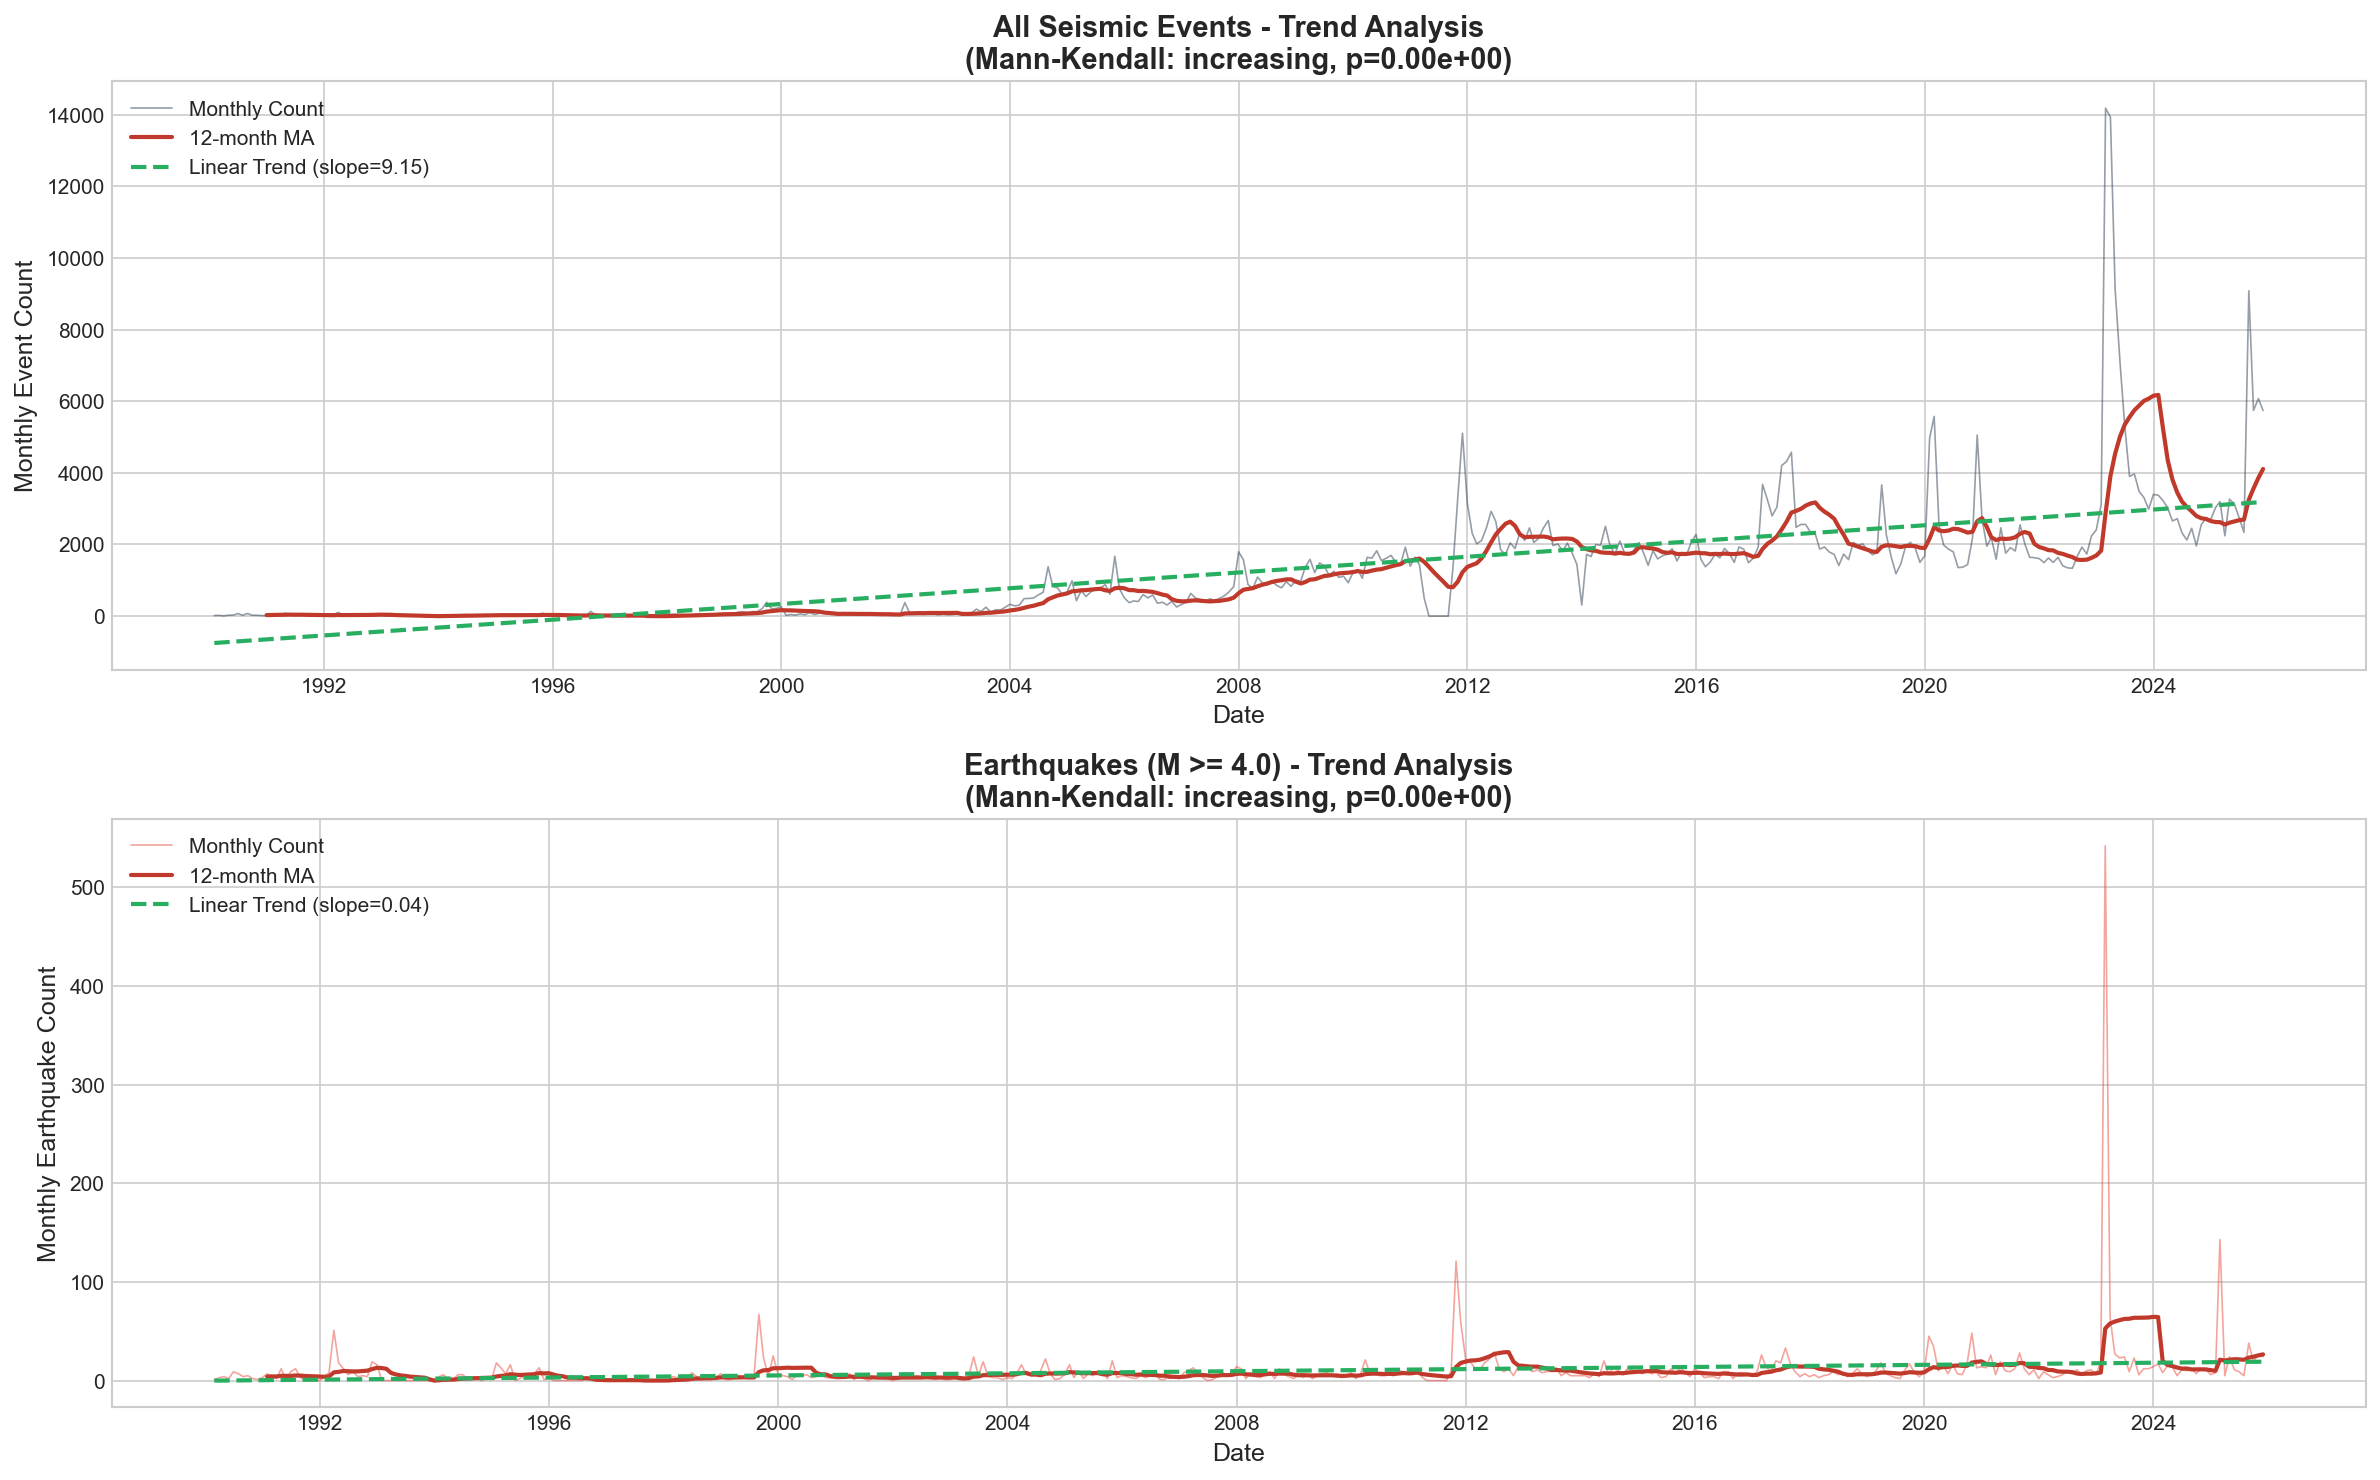

In [4]:
# Plot trends
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# All events
ax1 = axes[0]
ax1.plot(monthly_all.index, monthly_all['count'], color=COLORS['primary'], 
         alpha=0.5, linewidth=0.8, label='Monthly Count')

# 12-month moving average
ma12 = monthly_all['count'].rolling(window=12).mean()
ax1.plot(monthly_all.index, ma12, color=COLORS['danger'], linewidth=2, 
         label='12-month MA')

# Linear trend
x = np.arange(len(monthly_all))
slope, intercept, r, p, se = stats.linregress(x, monthly_all['count'].values)
trend_line = intercept + slope * x
ax1.plot(monthly_all.index, trend_line, color=COLORS['success'], linewidth=2, 
         linestyle='--', label=f'Linear Trend (slope={slope:.2f})')

ax1.set_xlabel('Date')
ax1.set_ylabel('Monthly Event Count')
ax1.set_title(f'All Seismic Events - Trend Analysis\n(Mann-Kendall: {mk_result_all["trend"]}, p={mk_result_all["p_value"]:.2e})', 
              fontweight='bold')
ax1.legend()

# Earthquakes only
ax2 = axes[1]
ax2.plot(monthly_eq.index, monthly_eq['count'], color=COLORS['earthquake'], 
         alpha=0.5, linewidth=0.8, label='Monthly Count')

ma12_eq = monthly_eq['count'].rolling(window=12).mean()
ax2.plot(monthly_eq.index, ma12_eq, color=COLORS['danger'], linewidth=2, 
         label='12-month MA')

x_eq = np.arange(len(monthly_eq))
slope_eq, intercept_eq, r_eq, p_eq, se_eq = stats.linregress(x_eq, monthly_eq['count'].fillna(0).values)
trend_line_eq = intercept_eq + slope_eq * x_eq
ax2.plot(monthly_eq.index, trend_line_eq, color=COLORS['success'], linewidth=2, 
         linestyle='--', label=f'Linear Trend (slope={slope_eq:.2f})')

ax2.set_xlabel('Date')
ax2.set_ylabel('Monthly Earthquake Count')
ax2.set_title(f'Earthquakes (M >= 4.0) - Trend Analysis\n(Mann-Kendall: {mk_result_eq["trend"]}, p={mk_result_eq["p_value"]:.2e})', 
              fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'trend_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

## 3. Seasonality Analysis

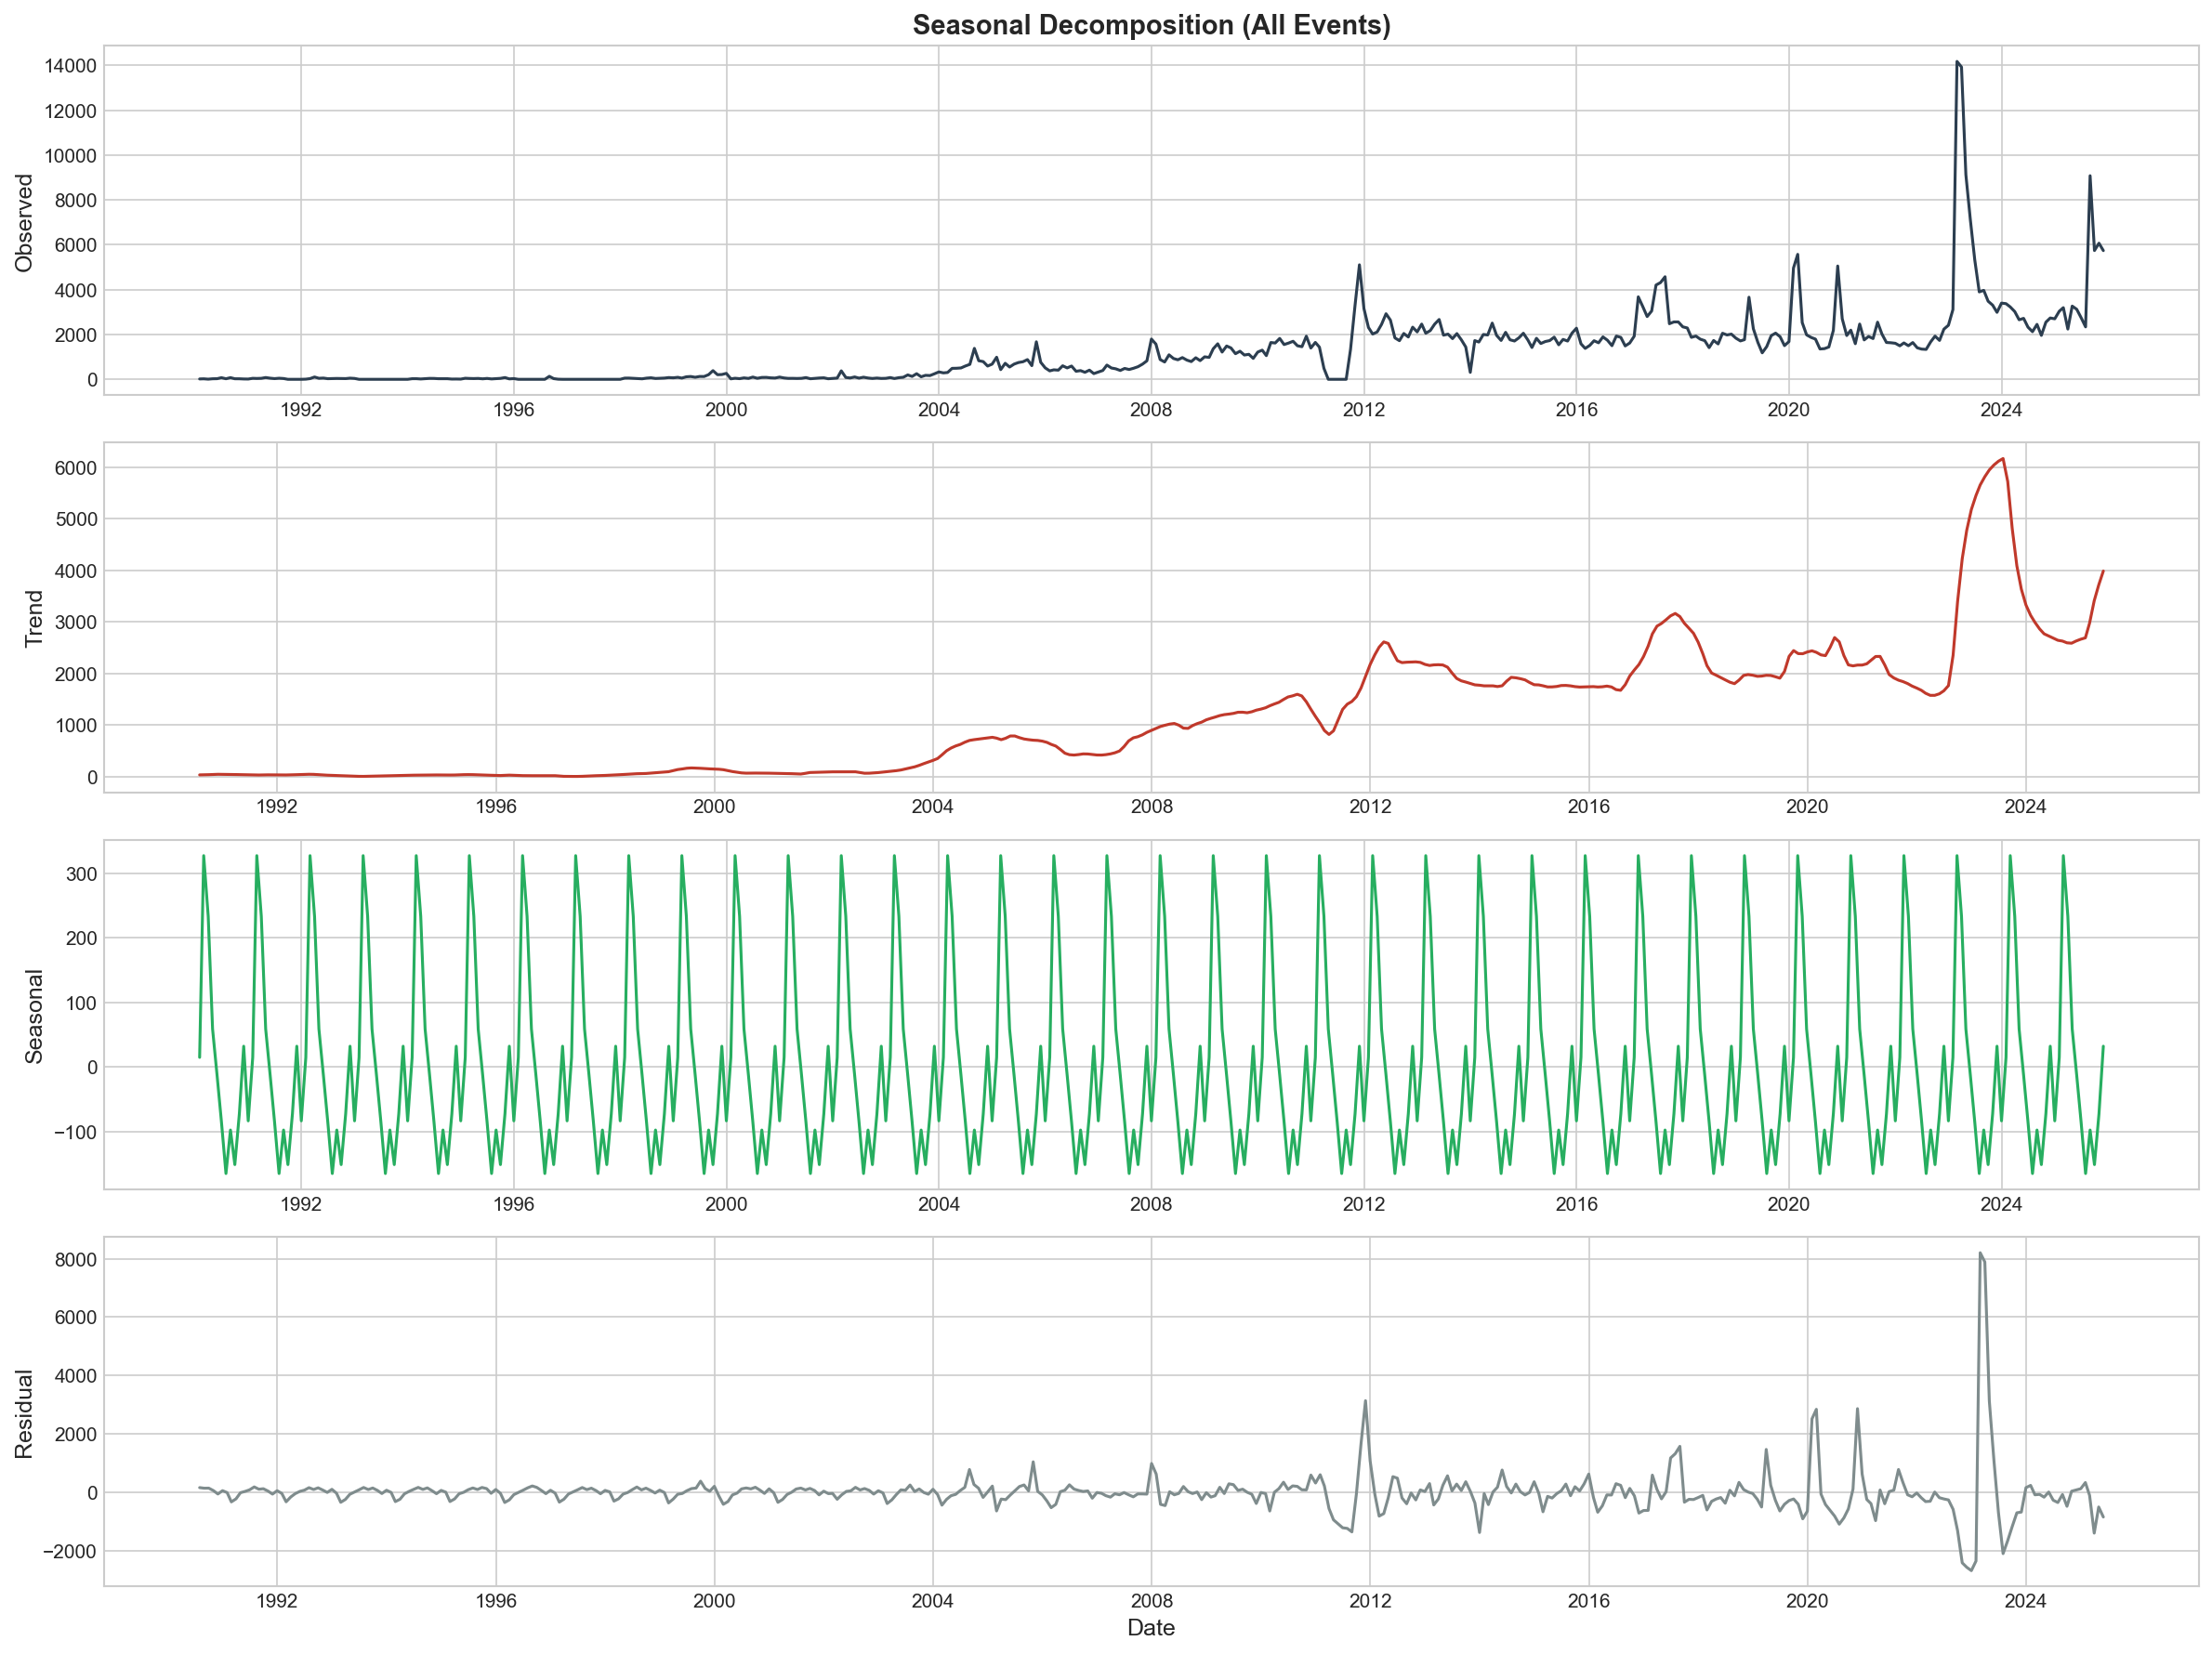

In [5]:
# Seasonal decomposition
# Use additive model for count data
decomposition = seasonal_decompose(monthly_all['count'].dropna(), model='additive', period=12)

fig, axes = plt.subplots(4, 1, figsize=(16, 12))

# Observed
axes[0].plot(decomposition.observed, color=COLORS['primary'])
axes[0].set_ylabel('Observed')
axes[0].set_title('Seasonal Decomposition (All Events)', fontweight='bold')

# Trend
axes[1].plot(decomposition.trend, color=COLORS['danger'])
axes[1].set_ylabel('Trend')

# Seasonal
axes[2].plot(decomposition.seasonal, color=COLORS['success'])
axes[2].set_ylabel('Seasonal')

# Residual
axes[3].plot(decomposition.resid, color=COLORS['secondary'])
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Date')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'seasonal_decomposition.png'), dpi=150, bbox_inches='tight')
plt.show()

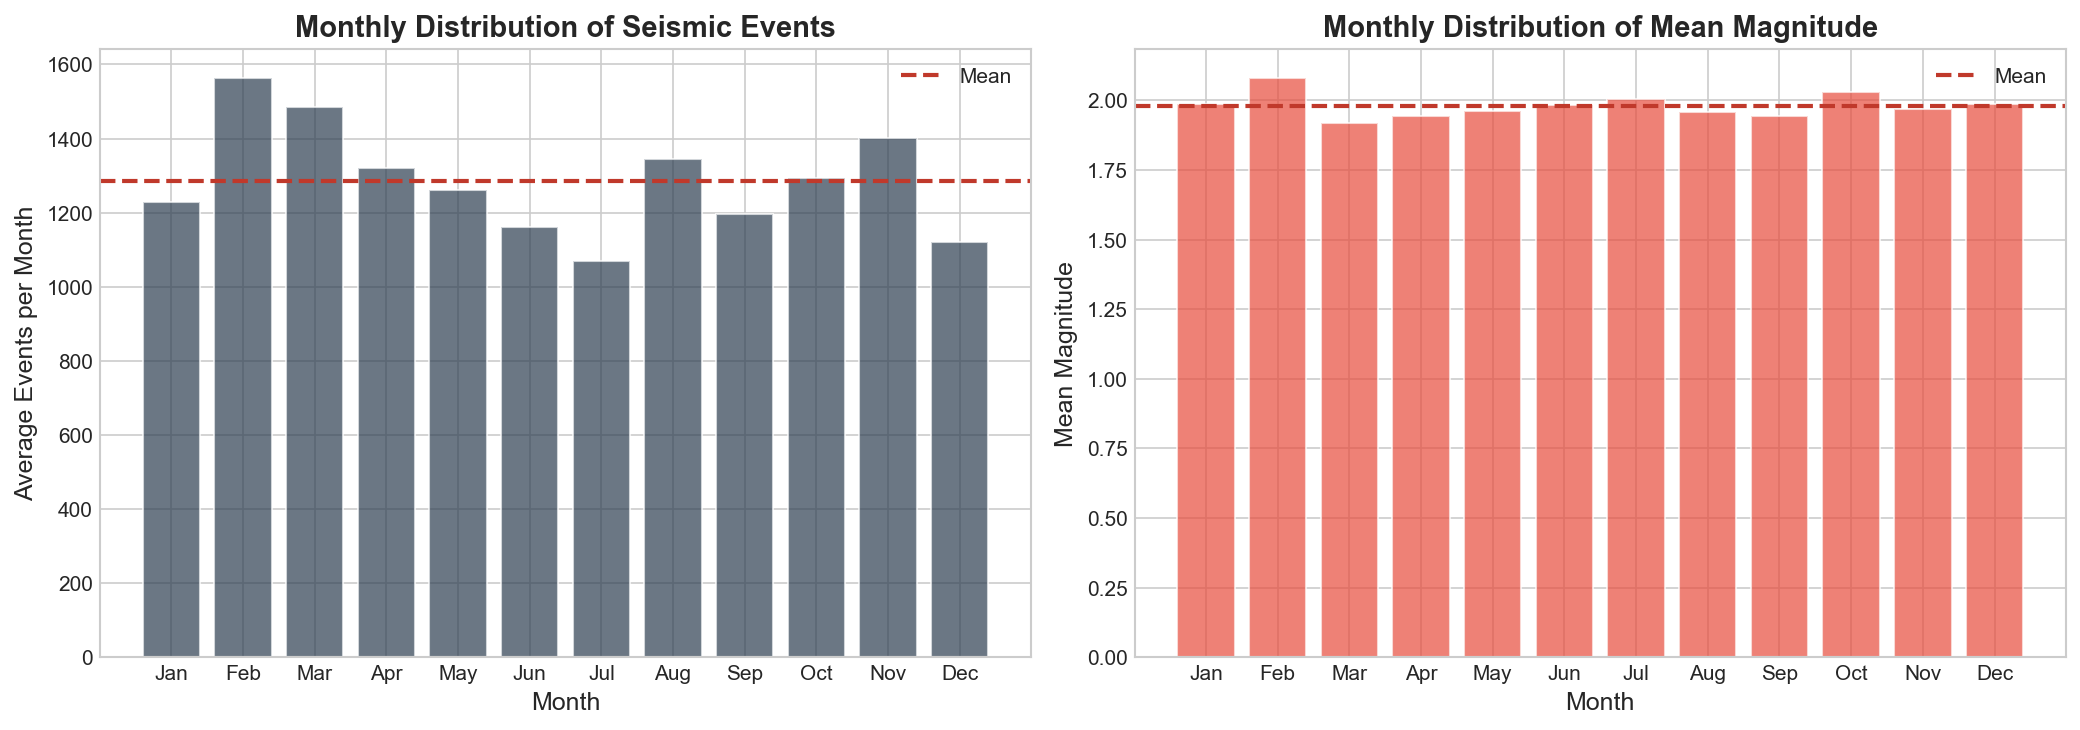


Chi-square test for monthly uniformity:
  Chi² = 6250.57, p-value = 0.0000e+00
  Result: NOT uniform (α=0.05)


In [6]:
# Monthly pattern analysis
monthly_pattern = eq_df.groupby('month').agg({
    'eventID': 'count',
    'magnitude': 'mean'
})
monthly_pattern.columns = ['count', 'mean_mag']

# Normalize by number of years
years_of_data = eq_df['year'].nunique()
monthly_pattern['avg_count'] = monthly_pattern['count'] / years_of_data

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Monthly counts
ax1 = axes[0]
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax1.bar(range(1, 13), monthly_pattern['avg_count'], color=COLORS['primary'], alpha=0.7, edgecolor='white')
ax1.axhline(monthly_pattern['avg_count'].mean(), color=COLORS['danger'], linestyle='--', 
            linewidth=2, label='Mean')
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(months)
ax1.set_xlabel('Month')
ax1.set_ylabel('Average Events per Month')
ax1.set_title('Monthly Distribution of Seismic Events', fontweight='bold')
ax1.legend()

# Monthly average magnitude
ax2 = axes[1]
ax2.bar(range(1, 13), monthly_pattern['mean_mag'], color=COLORS['earthquake'], alpha=0.7, edgecolor='white')
ax2.axhline(monthly_pattern['mean_mag'].mean(), color=COLORS['danger'], linestyle='--', 
            linewidth=2, label='Mean')
ax2.set_xticks(range(1, 13))
ax2.set_xticklabels(months)
ax2.set_xlabel('Month')
ax2.set_ylabel('Mean Magnitude')
ax2.set_title('Monthly Distribution of Mean Magnitude', fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'monthly_patterns.png'), dpi=150, bbox_inches='tight')
plt.show()

# Chi-square test for uniform monthly distribution
expected = np.full(12, monthly_pattern['count'].sum() / 12)
chi2, p_value = stats.chisquare(monthly_pattern['count'].values, expected)
print(f"\nChi-square test for monthly uniformity:")
print(f"  Chi² = {chi2:.2f}, p-value = {p_value:.4e}")
print(f"  Result: {'NOT uniform' if p_value < 0.05 else 'Uniform'} (α=0.05)")

## 4. Inter-Event Time Analysis

In [7]:
# Calculate inter-event times
earthquakes_sorted = earthquakes.sort_values('date').copy()
earthquakes_sorted['time_diff'] = earthquakes_sorted['date'].diff()
earthquakes_sorted['inter_event_days'] = earthquakes_sorted['time_diff'].dt.total_seconds() / 86400

# Remove first row (NaN) and any negative values
inter_event_times = earthquakes_sorted['inter_event_days'].dropna()
inter_event_times = inter_event_times[inter_event_times > 0]

print(f"Inter-event time statistics (M >= 4.0):")
print(f"  Mean: {inter_event_times.mean():.2f} days")
print(f"  Median: {inter_event_times.median():.2f} days")
print(f"  Std: {inter_event_times.std():.2f} days")
print(f"  Min: {inter_event_times.min():.4f} days ({inter_event_times.min()*24:.1f} hours)")
print(f"  Max: {inter_event_times.max():.1f} days")

Inter-event time statistics (M >= 4.0):
  Mean: 3.18 days
  Median: 0.68 days
  Std: 11.89 days
  Min: 0.0000 days (0.0 hours)
  Max: 464.3 days


In [8]:
# Fit distributions to inter-event times
distributions = ['exponential', 'weibull', 'gamma']
fit_results = {}

print("\nDistribution Fitting Results:")
print("-" * 60)

for dist in distributions:
    result = fit_interevent_distribution(inter_event_times.values, distribution=dist)
    fit_results[dist] = result
    
    print(f"\n{dist.capitalize()}:")
    print(f"  Parameters: {result['params']}")
    print(f"  KS statistic: {result['ks_statistic']:.4f}")
    print(f"  p-value: {result['p_value']:.4f}")
    print(f"  Good fit: {'Yes' if result['p_value'] > 0.05 else 'No'} (α=0.05)")


Distribution Fitting Results:
------------------------------------------------------------

Exponential:
  Parameters: {'rate': np.float64(0.31423613615244717)}
  KS statistic: 0.3246
  p-value: 0.0000
  Good fit: No (α=0.05)

Weibull:
  Parameters: {'shape': np.float64(0.4471281153577229), 'scale': np.float64(1.3156948931350687)}
  KS statistic: 0.0500
  p-value: 0.0000
  Good fit: No (α=0.05)

Gamma:
  Parameters: {'shape': 0.31308119347091373, 'scale': np.float64(10.16452043353705)}
  KS statistic: 0.0512
  p-value: 0.0000
  Good fit: No (α=0.05)


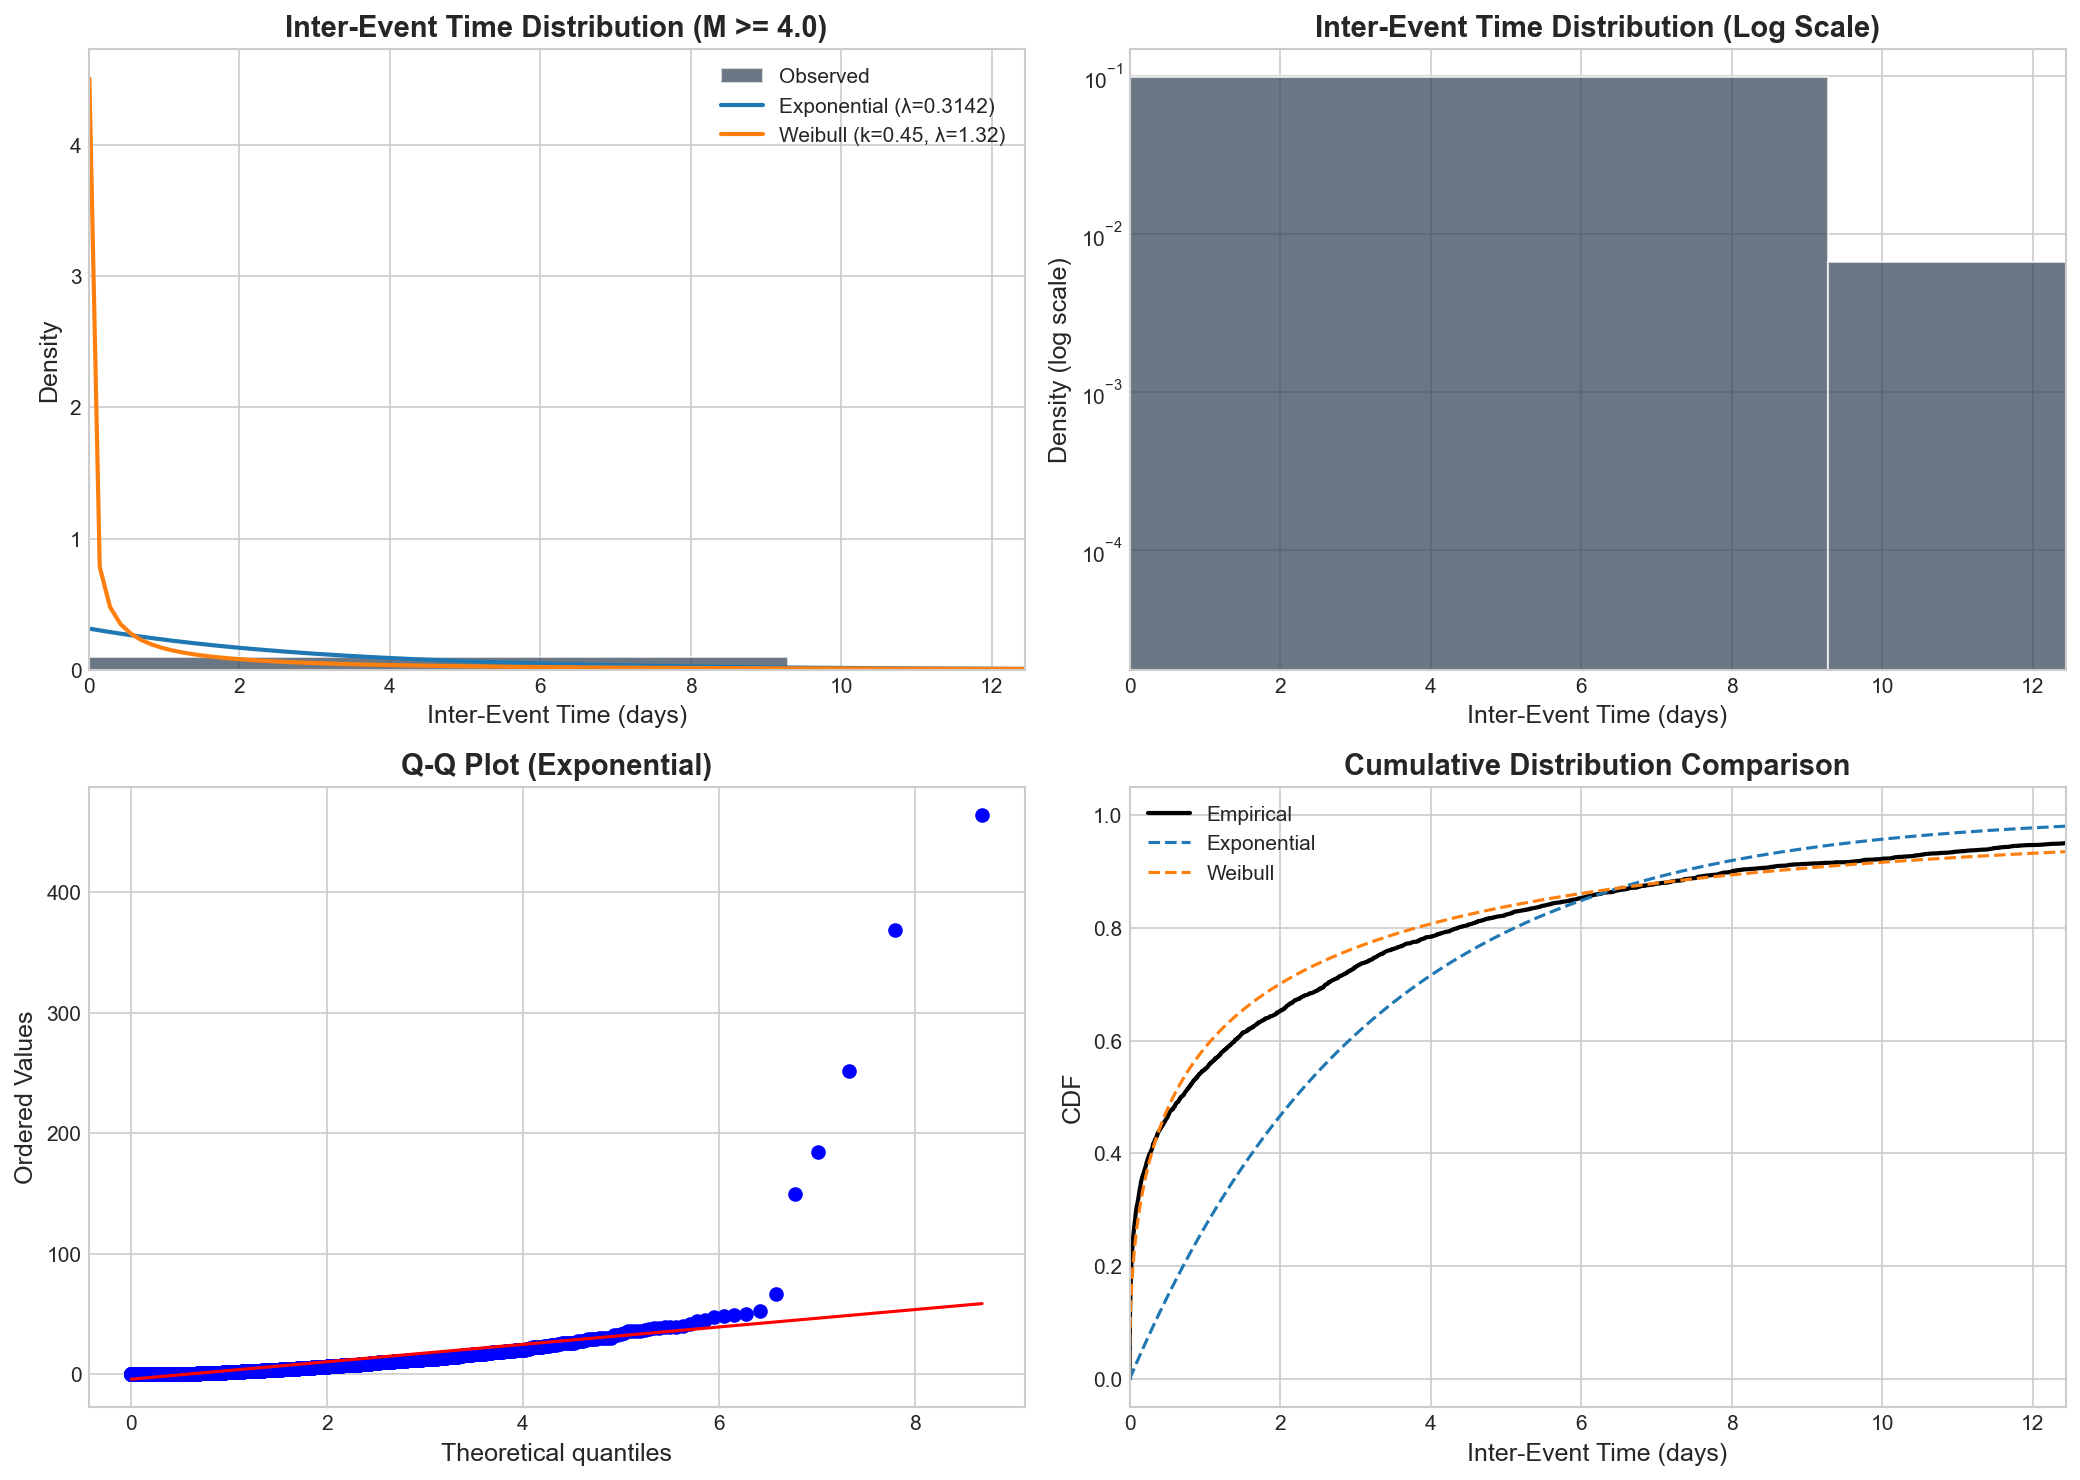

In [9]:
# Visualize inter-event time distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram
ax1 = axes[0, 0]
ax1.hist(inter_event_times, bins=50, density=True, alpha=0.7, 
         color=COLORS['primary'], edgecolor='white', label='Observed')

# Overlay fitted distributions
x = np.linspace(0.01, inter_event_times.quantile(0.99), 200)

# Exponential
rate = fit_results['exponential']['params']['rate']
y_exp = stats.expon.pdf(x, scale=1/rate)
ax1.plot(x, y_exp, label=f'Exponential (λ={rate:.4f})', linewidth=2)

# Weibull
shape_w = fit_results['weibull']['params']['shape']
scale_w = fit_results['weibull']['params']['scale']
y_weibull = stats.weibull_min.pdf(x, shape_w, scale=scale_w)
ax1.plot(x, y_weibull, label=f'Weibull (k={shape_w:.2f}, λ={scale_w:.2f})', linewidth=2)

ax1.set_xlabel('Inter-Event Time (days)')
ax1.set_ylabel('Density')
ax1.set_title('Inter-Event Time Distribution (M >= 4.0)', fontweight='bold')
ax1.legend()
ax1.set_xlim(0, inter_event_times.quantile(0.95))

# Log-scale histogram
ax2 = axes[0, 1]
ax2.hist(inter_event_times, bins=50, density=True, alpha=0.7, 
         color=COLORS['primary'], edgecolor='white')
ax2.set_xlabel('Inter-Event Time (days)')
ax2.set_ylabel('Density (log scale)')
ax2.set_title('Inter-Event Time Distribution (Log Scale)', fontweight='bold')
ax2.set_yscale('log')
ax2.set_xlim(0, inter_event_times.quantile(0.95))

# Q-Q plot for exponential
ax3 = axes[1, 0]
stats.probplot(inter_event_times, dist='expon', plot=ax3)
ax3.set_title('Q-Q Plot (Exponential)', fontweight='bold')

# CDF comparison
ax4 = axes[1, 1]
sorted_times = np.sort(inter_event_times)
empirical_cdf = np.arange(1, len(sorted_times) + 1) / len(sorted_times)

ax4.plot(sorted_times, empirical_cdf, 'k-', linewidth=2, label='Empirical')
ax4.plot(sorted_times, stats.expon.cdf(sorted_times, scale=1/rate), 
         '--', label='Exponential', linewidth=1.5)
ax4.plot(sorted_times, stats.weibull_min.cdf(sorted_times, shape_w, scale=scale_w), 
         '--', label='Weibull', linewidth=1.5)

ax4.set_xlabel('Inter-Event Time (days)')
ax4.set_ylabel('CDF')
ax4.set_title('Cumulative Distribution Comparison', fontweight='bold')
ax4.legend()
ax4.set_xlim(0, inter_event_times.quantile(0.95))

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'inter_event_time.png'), dpi=150, bbox_inches='tight')
plt.show()

## 5. Cumulative Analysis

In [10]:
# Calculate cumulative metrics
earthquakes_sorted['cumulative_count'] = range(1, len(earthquakes_sorted) + 1)
earthquakes_sorted['cumulative_energy'] = earthquakes_sorted['energy_joules'].cumsum()
earthquakes_sorted['cumulative_moment'] = earthquakes_sorted['moment_dyne_cm'].cumsum()

# Log-transformed cumulative energy
earthquakes_sorted['log_cum_energy'] = np.log10(earthquakes_sorted['cumulative_energy'])

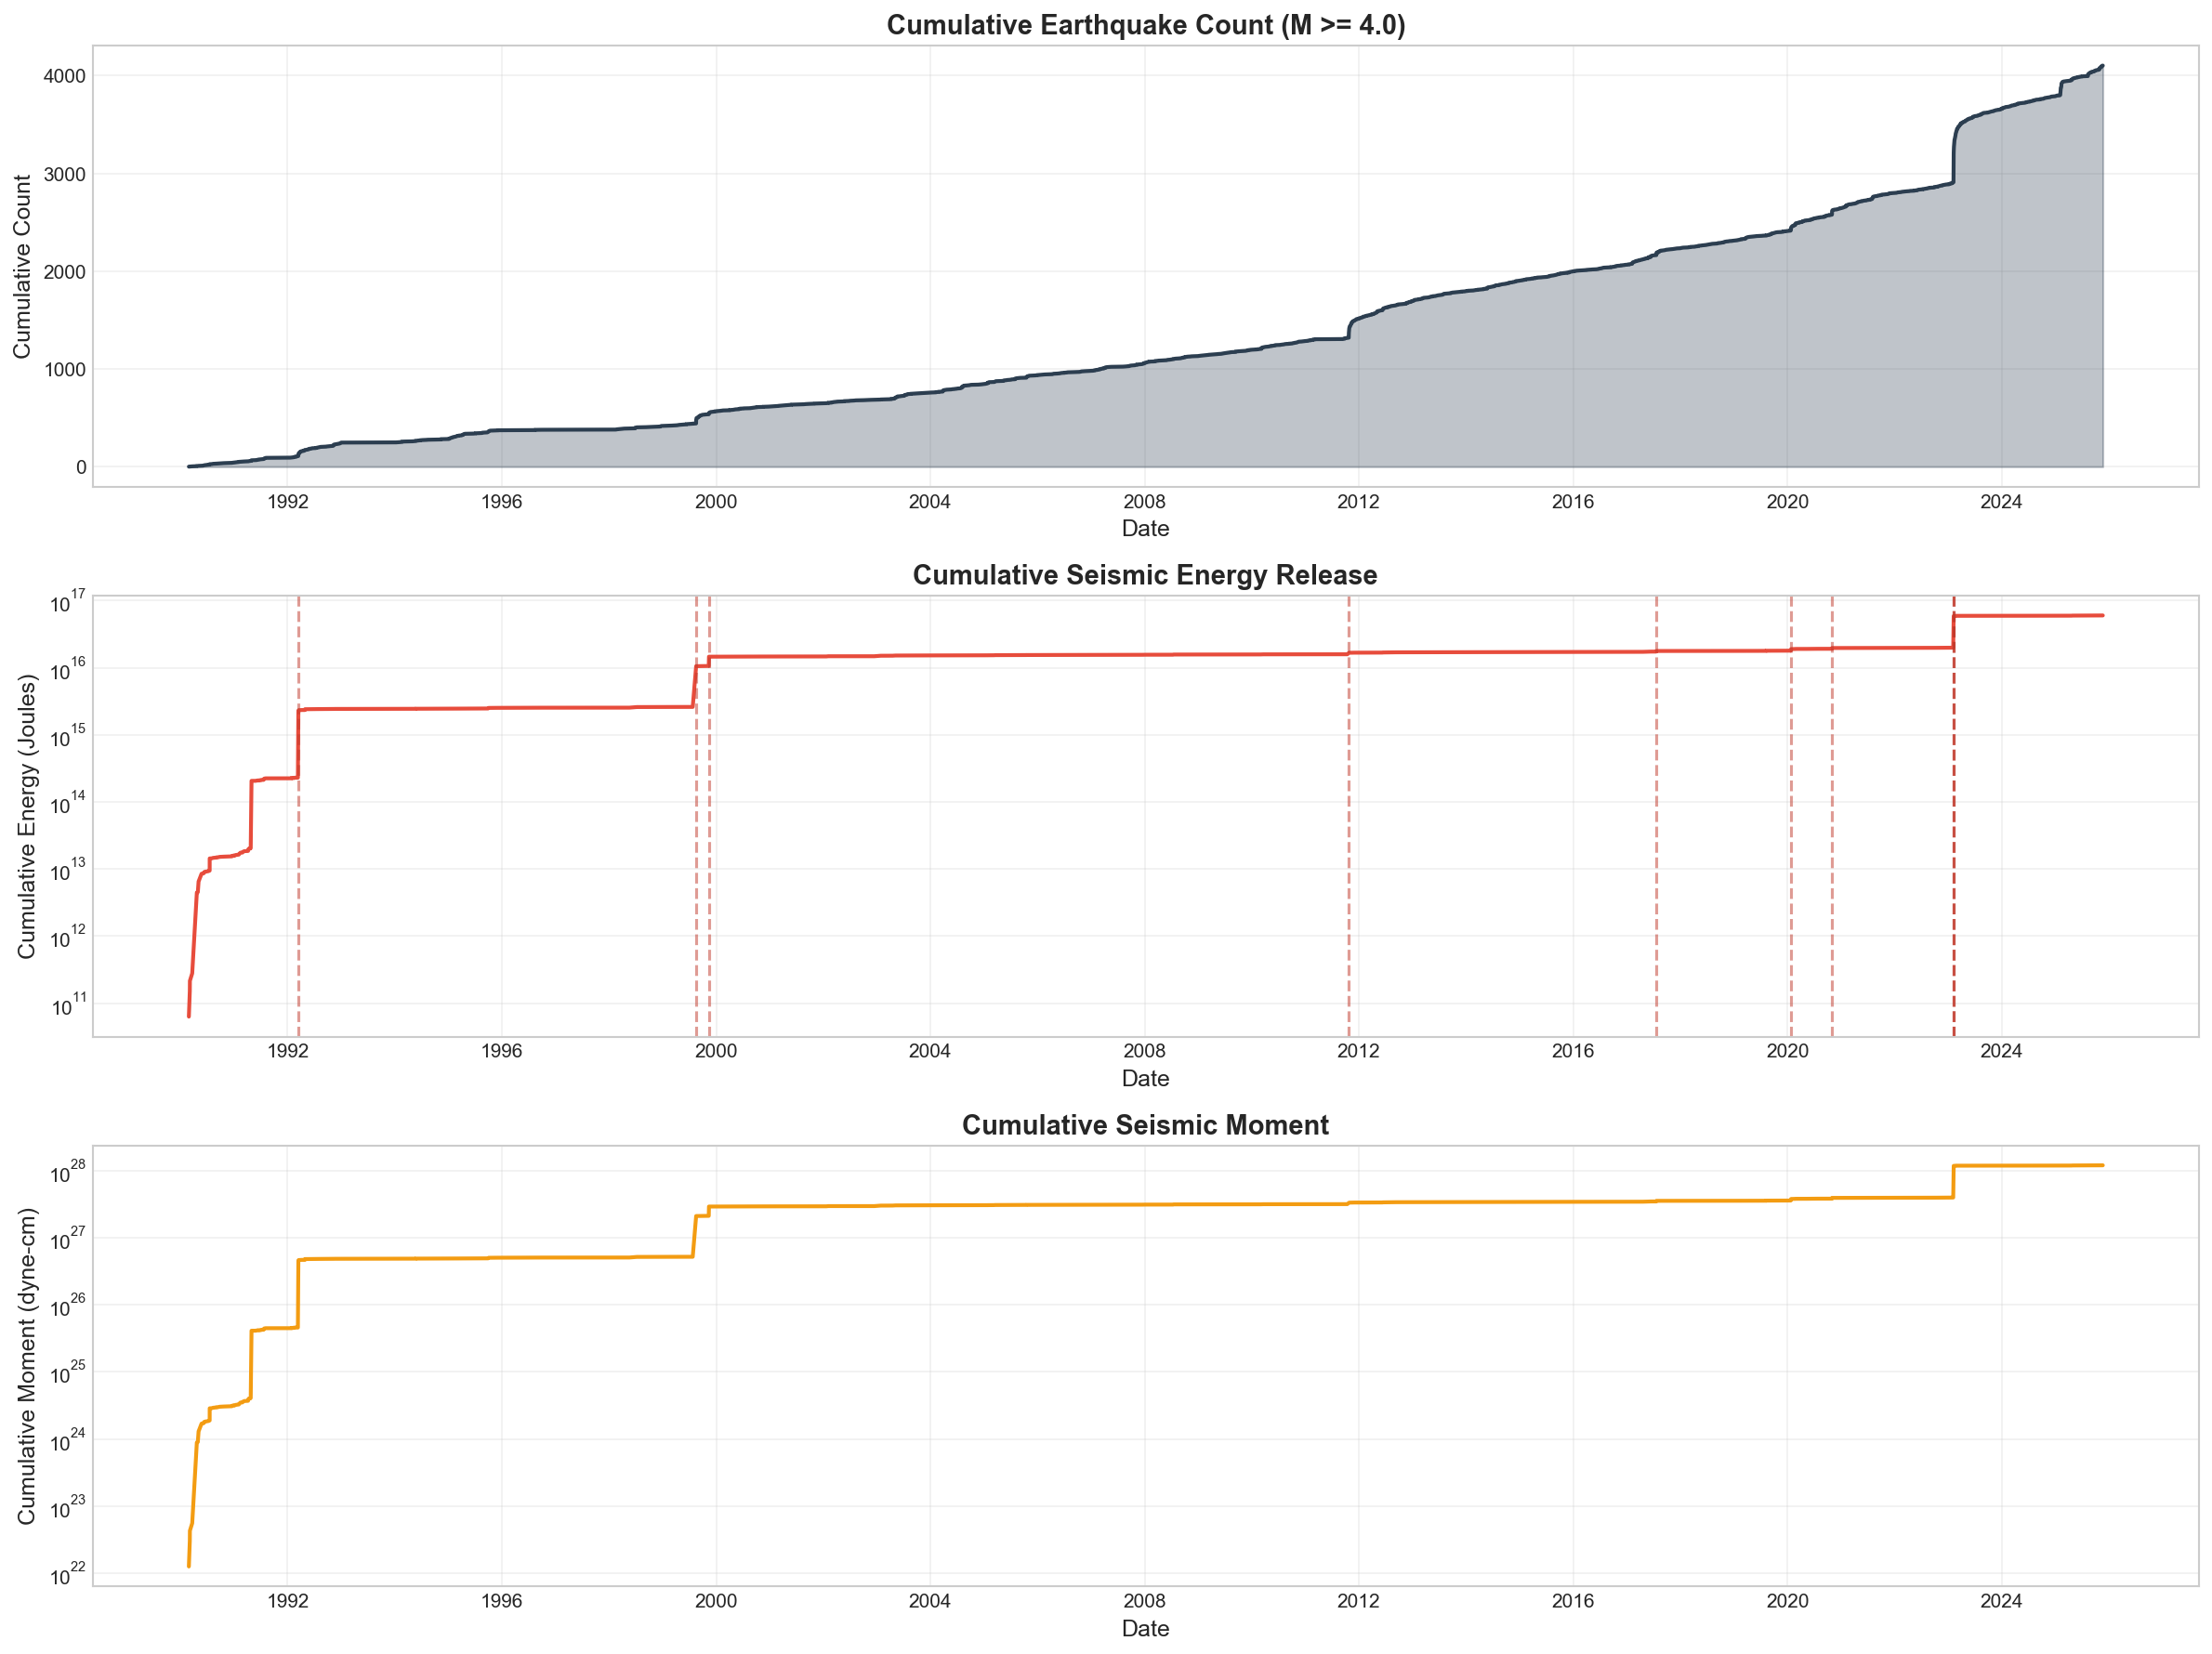

In [11]:
# Plot cumulative metrics
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Cumulative count
ax1 = axes[0]
ax1.plot(earthquakes_sorted['date'], earthquakes_sorted['cumulative_count'], 
         color=COLORS['primary'], linewidth=2)
ax1.fill_between(earthquakes_sorted['date'], 0, earthquakes_sorted['cumulative_count'], 
                  alpha=0.3, color=COLORS['primary'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Count')
ax1.set_title('Cumulative Earthquake Count (M >= 4.0)', fontweight='bold')
ax1.grid(alpha=0.3)

# Cumulative energy
ax2 = axes[1]
ax2.plot(earthquakes_sorted['date'], earthquakes_sorted['cumulative_energy'], 
         color=COLORS['earthquake'], linewidth=2)
ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative Energy (Joules)')
ax2.set_title('Cumulative Seismic Energy Release', fontweight='bold')
ax2.set_yscale('log')
ax2.grid(alpha=0.3)

# Mark major earthquakes
major_eq = earthquakes_sorted[earthquakes_sorted['magnitude'] >= 6.5]
for idx, eq in major_eq.iterrows():
    ax2.axvline(eq['date'], color=COLORS['danger'], linestyle='--', alpha=0.5)

# Cumulative moment
ax3 = axes[2]
ax3.plot(earthquakes_sorted['date'], earthquakes_sorted['cumulative_moment'], 
         color=COLORS['accent'], linewidth=2)
ax3.set_xlabel('Date')
ax3.set_ylabel('Cumulative Moment (dyne-cm)')
ax3.set_title('Cumulative Seismic Moment', fontweight='bold')
ax3.set_yscale('log')
ax3.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'cumulative_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

In [12]:
# Yearly cumulative statistics
yearly_summary = earthquakes.groupby('year').agg({
    'eventID': 'count',
    'magnitude': ['mean', 'max'],
    'energy_joules': 'sum',
    'moment_dyne_cm': 'sum'
}).round(2)
yearly_summary.columns = ['count', 'mean_mag', 'max_mag', 'total_energy', 'total_moment']

# Display significant years
print("\nTop 10 Years by Earthquake Count:")
print(yearly_summary.nlargest(10, 'count')[['count', 'max_mag', 'total_energy']])

print("\nTop 10 Years by Total Energy Release:")
print(yearly_summary.nlargest(10, 'total_energy')[['count', 'max_mag', 'total_energy']])


Top 10 Years by Earthquake Count:
      count  max_mag  total_energy
year                              
2023    775      7.7  3.965783e+16
2025    313      6.2  5.556057e+14
2020    234      6.8  1.742260e+15
2011    231      6.7  9.149739e+14
2012    179      6.0  2.317112e+14
2017    170      6.5  5.801303e+14
1992    156      7.0  2.209904e+15
2021    154      5.5  7.880792e+13
1999    150      7.4  1.202736e+16
2024    128      5.9  1.011264e+14

Top 10 Years by Total Energy Release:
      count  max_mag  total_energy
year                              
2023    775      7.7  3.965783e+16
1999    150      7.4  1.202736e+16
1992    156      7.0  2.209904e+15
2020    234      6.8  1.742260e+15
2011    231      6.7  9.149739e+14
2017    170      6.5  5.801303e+14
2025    313      6.2  5.556057e+14
2003     72      6.4  4.235325e+14
2012    179      6.0  2.317112e+14
1991     50      6.2  2.088855e+14


## 6. Omori Law (Aftershock Analysis)

In [13]:
# Find major earthquakes for aftershock analysis
major_earthquakes = earthquakes[earthquakes['magnitude'] >= 6.5].copy()
print(f"Major earthquakes (M >= 6.5): {len(major_earthquakes)}")

if len(major_earthquakes) > 0:
    print("\nMajor Earthquakes:")
    print(major_earthquakes[['date', 'magnitude', 'latitude', 'longitude', 'province']].to_string())

Major earthquakes (M >= 6.5): 10

Major Earthquakes:
                          date  magnitude  latitude  longitude       province
771    1992-03-13 17:18:41.000        7.0  40.00000   40.00000       Erzincan
3473   1999-08-17 00:01:39.070        7.4  40.70000   29.91000        Kocaeli
4262   1999-11-12 16:57:21.410        7.2  40.79000   31.21000          Düzce
96168  2011-10-23 10:41:20.810        6.7  38.68900   43.46570            Van
219792 2017-07-20 22:31:09.880        6.5  36.91980   27.44350          Muğla
298029 2020-01-24 17:55:11.390        6.8  38.35930   39.06300         Elazığ
325253 2020-10-30 11:51:23.000        6.6  37.87900   26.70300          İzmir
373264 2023-02-06 01:17:32.000        7.7  37.27728   37.03996  Kahramanmaraş
407133 2023-02-06 01:28:16.000        6.6  37.29414   36.91613      Gaziantep
376171 2023-02-06 10:24:47.000        7.6  38.07800   37.23097  Kahramanmaraş


In [14]:
# Analyze aftershock sequences for major events
if len(major_earthquakes) > 0:
    # Select the largest earthquake
    mainshock = major_earthquakes.loc[major_earthquakes['magnitude'].idxmax()]
    
    print(f"\nAnalyzing aftershocks for:")
    print(f"  Date: {mainshock['date']}")
    print(f"  Magnitude: {mainshock['magnitude']}")
    print(f"  Location: {mainshock['province']}")
    
    # Get aftershocks (within 100 km and 1 year)
    from geo_utils import haversine_distance
    
    max_days = 365
    max_distance = 100  # km
    min_mag = mainshock['magnitude'] - 2
    
    aftershock_mask = (
        (eq_df['date'] > mainshock['date']) &
        (eq_df['date'] <= mainshock['date'] + pd.Timedelta(days=max_days)) &
        (eq_df['magnitude'] >= min_mag)
    )
    
    # Calculate distance to mainshock
    potential_aftershocks = eq_df[aftershock_mask].copy()
    potential_aftershocks['distance_km'] = potential_aftershocks.apply(
        lambda row: haversine_distance(
            row['latitude'], row['longitude'],
            mainshock['latitude'], mainshock['longitude']
        ), axis=1
    )
    
    aftershocks = potential_aftershocks[potential_aftershocks['distance_km'] <= max_distance].copy()
    aftershocks['days_after'] = (aftershocks['date'] - mainshock['date']).dt.total_seconds() / 86400
    
    print(f"\n  Aftershocks found: {len(aftershocks)}")


Analyzing aftershocks for:
  Date: 2023-02-06 01:17:32
  Magnitude: 7.7
  Location: Kahramanmaraş

  Aftershocks found: 3


In [15]:
# Plot aftershock decay (Omori-style)
if len(major_earthquakes) > 0 and len(aftershocks) > 10:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Cumulative aftershocks
    ax1 = axes[0]
    aftershocks_sorted = aftershocks.sort_values('days_after')
    ax1.plot(aftershocks_sorted['days_after'], 
             np.arange(1, len(aftershocks_sorted) + 1),
             color=COLORS['primary'], linewidth=2)
    ax1.set_xlabel('Days After Mainshock')
    ax1.set_ylabel('Cumulative Aftershock Count')
    ax1.set_title(f'Cumulative Aftershock Sequence\n(M{mainshock["magnitude"]} {mainshock["date"].strftime("%Y-%m-%d")})', 
                  fontweight='bold')
    ax1.grid(alpha=0.3)
    
    # Aftershock rate decay
    ax2 = axes[1]
    
    # Bin aftershocks by time
    bins = np.logspace(-1, np.log10(max_days), 30)
    counts, bin_edges = np.histogram(aftershocks['days_after'], bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_widths = np.diff(bin_edges)
    rates = counts / bin_widths
    
    ax2.scatter(bin_centers[rates > 0], rates[rates > 0], 
                color=COLORS['primary'], s=50, alpha=0.7)
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel('Days After Mainshock')
    ax2.set_ylabel('Aftershock Rate (events/day)')
    ax2.set_title('Aftershock Rate Decay (Omori-Style)', fontweight='bold')
    ax2.grid(alpha=0.3)
    
    # Fit Omori law: n(t) = K / (t + c)^p
    # In log-log: log(n) = log(K) - p*log(t+c)
    valid = rates > 0
    if valid.sum() > 5:
        c = 0.1  # Small constant
        log_t = np.log10(bin_centers[valid] + c)
        log_rate = np.log10(rates[valid])
        
        slope, intercept, r, p, se = stats.linregress(log_t, log_rate)
        
        # Plot fit
        t_fit = np.logspace(-1, np.log10(max_days), 100)
        rate_fit = 10**intercept * (t_fit + c)**slope
        ax2.plot(t_fit, rate_fit, '--', color=COLORS['danger'], linewidth=2,
                 label=f'Omori fit (p = {-slope:.2f})')
        ax2.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'aftershock_analysis.png'), dpi=150, bbox_inches='tight')
    plt.show()

## 7. Export Results

In [16]:
# Save results
results = {
    'Metric': [
        'Mann-Kendall S (all events)',
        'Mann-Kendall p-value (all events)',
        'Trend (all events)',
        'Mann-Kendall S (M>=4)',
        'Mann-Kendall p-value (M>=4)',
        'Trend (M>=4)',
        'Mean inter-event time (days)',
        'Best fit distribution',
        'Exponential KS p-value',
        'Weibull KS p-value'
    ],
    'Value': [
        mk_result_all['S'],
        f"{mk_result_all['p_value']:.4e}",
        mk_result_all['trend'],
        mk_result_eq['S'],
        f"{mk_result_eq['p_value']:.4e}",
        mk_result_eq['trend'],
        f"{inter_event_times.mean():.2f}",
        max(fit_results.keys(), key=lambda x: fit_results[x]['p_value']),
        f"{fit_results['exponential']['p_value']:.4f}",
        f"{fit_results['weibull']['p_value']:.4f}"
    ]
}

results_df = pd.DataFrame(results)
results_df.to_csv(os.path.join(TABLES_PATH, 'time_series_results.csv'), index=False)
print(f"Results saved to: {os.path.join(TABLES_PATH, 'time_series_results.csv')}")

# Save yearly summary
yearly_summary.to_csv(os.path.join(TABLES_PATH, 'yearly_earthquake_summary.csv'))
print(f"Yearly summary saved to: {os.path.join(TABLES_PATH, 'yearly_earthquake_summary.csv')}")

Results saved to: /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/tables/time_series_results.csv
Yearly summary saved to: /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/tables/yearly_earthquake_summary.csv


In [17]:
print("\n" + "=" * 60)
print("TIME SERIES ANALYSIS COMPLETE")
print("=" * 60)
print(f"\nKey Findings:")
print(f"  - Trend in all events: {mk_result_all['trend']}")
print(f"  - Trend in earthquakes (M>=4): {mk_result_eq['trend']}")
print(f"  - Mean inter-event time: {inter_event_times.mean():.2f} days")
best_fit = max(fit_results.keys(), key=lambda x: fit_results[x]['p_value'])
print(f"  - Best fitting distribution: {best_fit}")
print(f"\nFigures saved to: {OUTPUT_DIR}")


TIME SERIES ANALYSIS COMPLETE

Key Findings:
  - Trend in all events: increasing
  - Trend in earthquakes (M>=4): increasing
  - Mean inter-event time: 3.18 days
  - Best fitting distribution: weibull

Figures saved to: /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/figures/06_time_series
